In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import textwrap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence
from skopt import gp_minimize

import shap
shap.initjs()

In [72]:
db = pd.read_csv('Combined_data.csv')
db.head()

,Type of crack,Crack length,a,b,t/b,Type of BCs,kx,ky,Omega
0,0,0.1,1,1,0.001,0,0.0,0.0,5.8673
1,0,0.1,1,1,0.001,0,0.0,0.5,3.2443
2,0,0.1,1,1,0.001,0,0.0,1.0,2.7955
3,0,0.1,1,1,0.001,0,0.0,5.0,2.4699
4,0,0.1,1,1,0.001,0,0.0,50.0,2.4656


In [73]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type of crack  3000 non-null   int64  
 1   Crack length   3000 non-null   float64
 2   a              3000 non-null   int64  
 3   b              3000 non-null   int64  
 4   t/b            3000 non-null   float64
 5   Type of BCs    3000 non-null   int64  
 6   kx             3000 non-null   float64
 7   ky             3000 non-null   float64
 8   Omega          3000 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 211.1 KB


In [74]:
X = db.iloc[:,:-1]
X.head()

,Type of crack,Crack length,a,b,t/b,Type of BCs,kx,ky
0,0,0.1,1,1,0.001,0,0.0,0.0
1,0,0.1,1,1,0.001,0,0.0,0.5
2,0,0.1,1,1,0.001,0,0.0,1.0
3,0,0.1,1,1,0.001,0,0.0,5.0
4,0,0.1,1,1,0.001,0,0.0,50.0


In [75]:
y = pd.DataFrame(db.iloc[:,-1])
y.head()

,Omega
0,5.8673
1,3.2443
2,2.7955
3,2.4699
4,2.4656


In [76]:
features = X.columns.values
features

array(['Type of crack', 'Crack length', 'a', 'b', 't/b', 'Type of BCs',
       'kx', 'ky'], dtype=object)

In [77]:
response = y.columns.values
response

array(['Omega'], dtype=object)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [79]:
from sklearn import metrics

# Function to return the mean of the metric for a particular metric name
def metrics_mean(y_ac, y_pred, metric):
    scores = []
    if metric == 'rmse':
        score = round(np.sqrt(metrics.mean_squared_error(y_ac, y_pred)),3)
    elif metric == 'mae':
        score = round(metrics.mean_absolute_error(y_ac, y_pred),3)
    elif metric == 'R2':
        score = round(metrics.r2_score(y_ac, y_pred),3)
    else:
        score = np.inf
    scores.append(score)
    return np.mean(scores)

# Final function "plot" to plot the train-train predicted values, test-test predicted values and the metrics for
# each ML algorithm used
def plot(regressor_name, y_train, y_train_pred, y_test, y_test_pred):

    plt.figure(figsize = (14,6))

    # First subplot - training set
    ax1 = plt.subplot(121)

    # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
    y_pred_train = pd.DataFrame(y_train_pred)
    plt.scatter(y_train,y_pred_train)
    plt.plot(y_train,y_train,'k--',lw=3)

    plt.xlabel('True Value',fontsize=16)
    plt.ylabel('Predicted Value',fontsize=16)

    # calculate means of the metrics
    rmse = metrics_mean(y_train,y_pred_train,'rmse')
    mae = metrics_mean(y_train,y_pred_train,'mae')
    R2 = metrics_mean(y_train,y_pred_train,'R2')

    # regressor name with all metrics in the title
    plt.title(regressor_name+' training set'
              +'\nRMSE: '+str(rmse)
              +'\nMAE: '+str(mae)
              +'\nR2: '+str(R2),fontsize=16)

    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)

    # Second subplot - test set
    ax2 = plt.subplot(122)

    # plot "predicted values vs actual values and true predictions" graph for test set using first prediction
    y_pred_test = pd.DataFrame(y_test_pred)
    plt.scatter(y_test,y_pred_test)
    plt.plot(y_test,y_test,'k--',lw=3)

    plt.xlabel('True Value',fontsize=16)
    plt.ylabel('Predicted Value',fontsize=16)

    # calculate means of the metrics
    rmse = metrics_mean(y_test,y_pred_test,'rmse')
    mae = metrics_mean(y_test,y_pred_test,'mae')
    R2 = metrics_mean(y_test,y_pred_test,'R2')

    # regressor name with all metrics in the title
    plt.title(regressor_name+' test set'
              +'\nRMSE: '+str(rmse)
              +'\nMAE: '+str(mae)
              +'\nR2: '+str(R2),fontsize=16)

    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)

    plt.show()

    # return metrics for test set to record the errors across different algorithms
    return rmse, mae, R2

In [80]:
rmse_scores = {}
mae_scores = {}
R2_scores = {}
time_reg = {}
time_hpopt = {}

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

## Linear Regression

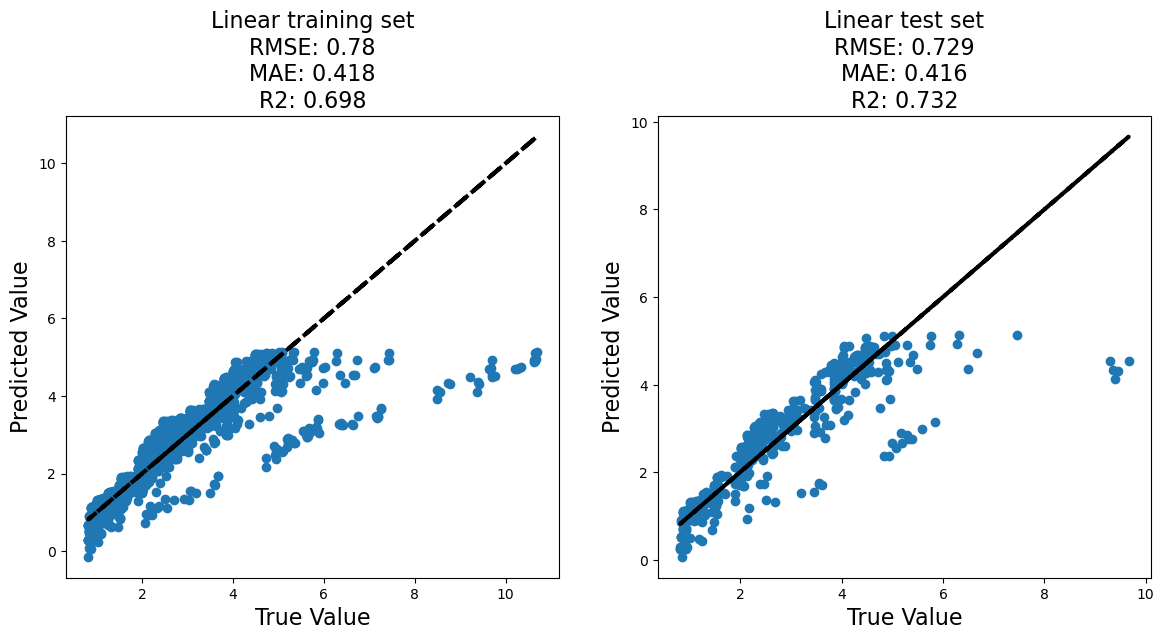

In [82]:
start_time = time.time()

# create a Linear Regression regressor
lregressor = LinearRegression()

# fit and predict all the train/test arrays
lregressor.fit(X_train,y_train)
y_pred_train = lregressor.predict(X_train)
y_pred_test = lregressor.predict(X_test)

# plot the training results
rmse, mae, R2 = plot('Linear', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Linear'] = rmse
mae_scores['Linear'] = mae
R2_scores['Linear'] = R2

end_time = time.time()
time_reg['Linear'] = end_time - start_time

In [83]:
# plot coefficients as Importance
def plot_coef(importance, features, title):

    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.barh(range(len(importance)), importance, tick_label=features)
    plt.xticks(fontsize=10)
    plt.xlabel('Importance')
    plt.title(title, fontsize=16)
    plt.show()

Feature: 0, Score: -0.23222
Feature: 1, Score: -0.96772
Feature: 2, Score: -1.44836
Feature: 3, Score: 0.00000
Feature: 4, Score: -2.15533
Feature: 5, Score: 1.74034
Feature: 6, Score: -0.00861
Feature: 7, Score: -0.00882


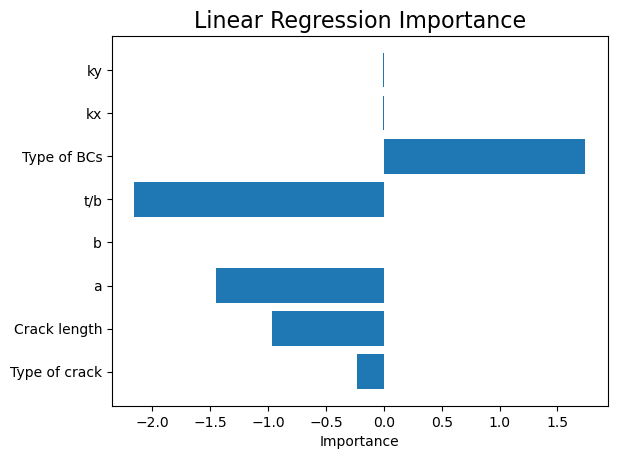

In [84]:
plot_coef(lregressor.coef_.flatten(), features, 'Linear Regression Importance')

## Ridge Regression

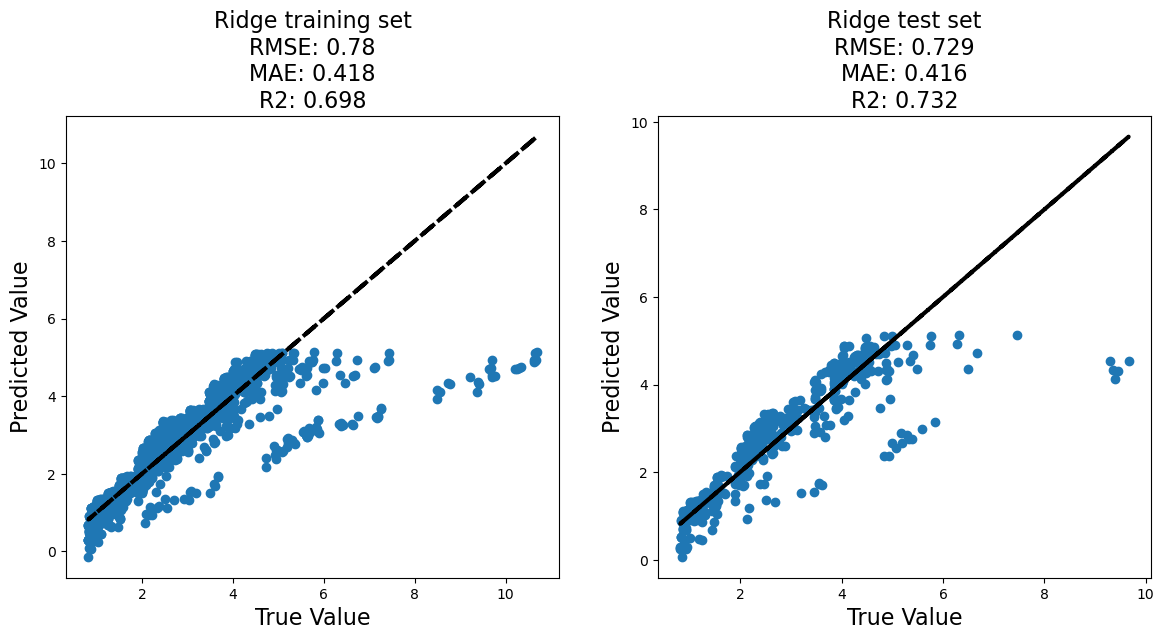

In [85]:
#RidgeCV for best alpha
from sklearn.linear_model import RidgeCV

start_time = time.time()

ridgecv = RidgeCV(alphas = np.logspace(-6,6,104))
ridgecv.fit(X_train, y_train)

end_time = time.time()
time_hpopt['Ridge'] = end_time - start_time

start_time = time.time()

# Ridge Regression
rregressor = Ridge(alpha = ridgecv.alpha_)

rregressor.fit(X_train,y_train)
y_pred_train = rregressor.predict(X_train)
y_pred_test = rregressor.predict(X_test)

rmse, mae, R2 = plot('Ridge', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Ridge'] = rmse
mae_scores['Ridge'] = mae
R2_scores['Ridge'] = R2

end_time = time.time()
time_reg['Ridge'] = end_time - start_time

In [86]:
ridgecv.alpha_

np.float64(0.13372530349989456)

Feature: 0, Score: -0.23219
Feature: 1, Score: -0.96711
Feature: 2, Score: -1.44806
Feature: 3, Score: 0.00000
Feature: 4, Score: -2.09726
Feature: 5, Score: 1.73989
Feature: 6, Score: -0.00861
Feature: 7, Score: -0.00882


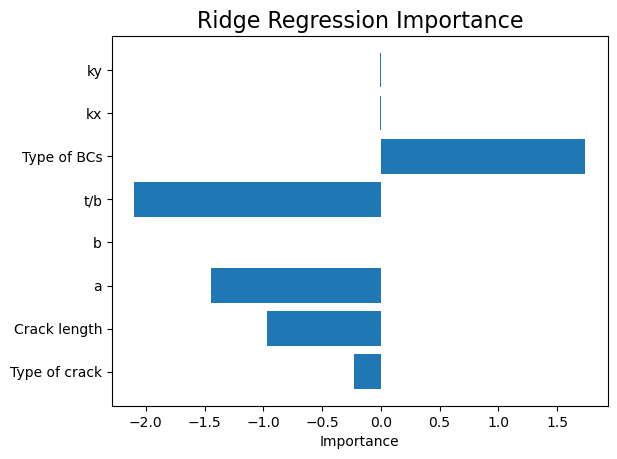

In [87]:
plot_coef(rregressor.coef_.flatten(), features, 'Ridge Regression Importance')

## Lasso Regression

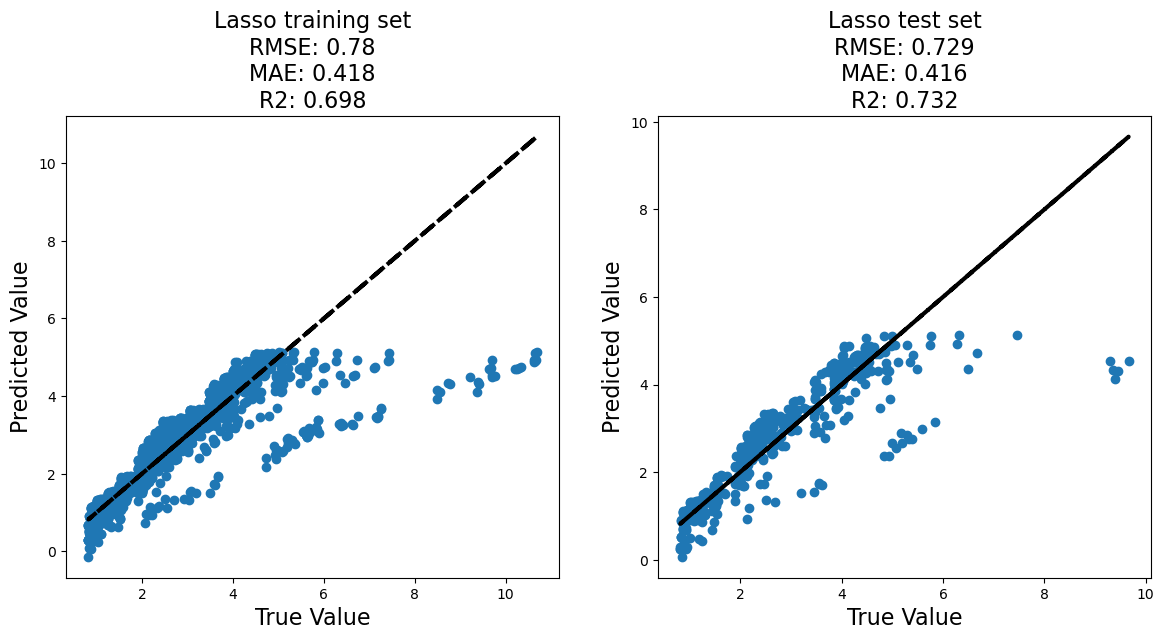

In [88]:
#LassoCV for best alpha
from sklearn.linear_model import LassoCV

y_ravel = y_train.to_numpy().ravel()

start_time = time.time()

lassocv = LassoCV(alphas = np.logspace(-6,6,104))
lassocv.fit(X_train, y_ravel)

end_time = time.time()
time_hpopt['Lasso'] = end_time - start_time

start_time = time.time()

# Lasso Regression
lsregressor = Lasso(alpha = lassocv.alpha_)

lsregressor.fit(X_train,y_train)
y_pred_train = lsregressor.predict(X_train).reshape(-1,1)
y_pred_test = lsregressor.predict(X_test).reshape(-1,1)

rmse, mae, R2 = plot('Lasso', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Lasso'] = rmse
mae_scores['Lasso'] = mae
R2_scores['Lasso'] = R2

end_time = time.time()
time_reg['Lasso'] = end_time - start_time

In [89]:
lassocv.alpha_

np.float64(5.5920727861952215e-05)

Feature: 0, Score: -0.23201
Feature: 1, Score: -0.96705
Feature: 2, Score: -1.44814
Feature: 3, Score: 0.00000
Feature: 4, Score: -2.12757
Feature: 5, Score: 1.74008
Feature: 6, Score: -0.00861
Feature: 7, Score: -0.00882


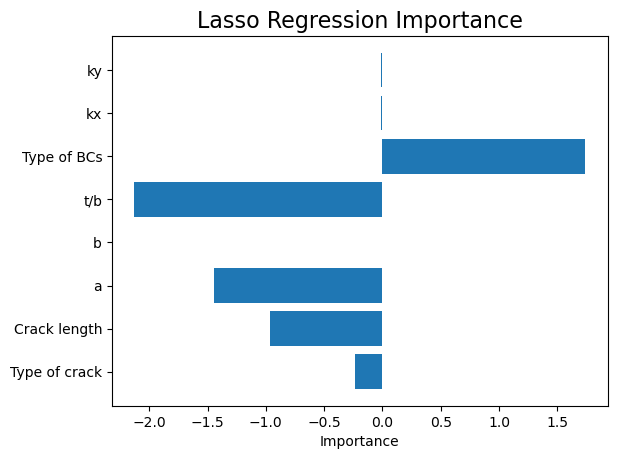

In [90]:
plot_coef(lsregressor.coef_.flatten(), features, 'Lasso Regression Importance')

## k-Neighbors Regression

### Hyperparameter optimization

In [91]:
start_time = time.time()

# Hyperparameter optimization of k-Neighbors Regressor
knregressor = KNeighborsRegressor()

knr_space  = [Integer(2, 11, name='n_neighbors'),
              Categorical(categories=['auto', 'brute', 'ball_tree', 'kd_tree'], name='algorithm'),
              Integer(1, 10, name='leaf_size'),
              Integer(1, 5, name='p')]

@use_named_args(knr_space)
def objective(**params):
    knregressor.set_params(**params)
    return -np.mean(cross_val_score(knregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

knr_gp = gp_minimize(objective, knr_space, n_calls=100, n_jobs=-1, random_state=0)

end_time = time.time()
time_hpopt['k-Nearest Neighbors'] = end_time - start_time

D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.str_('brute'), np.int64(1), np.int64(1)] before, using random point [np.int64(10), 'kd_tree', np.int64(3), np.int64(2)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.str_('auto'), np.int64(1), np.int64(1)] before, using random point [np.int64(2), 'kd_tree', np.int64(3), np.int64(2)]
  warnings.warn(


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

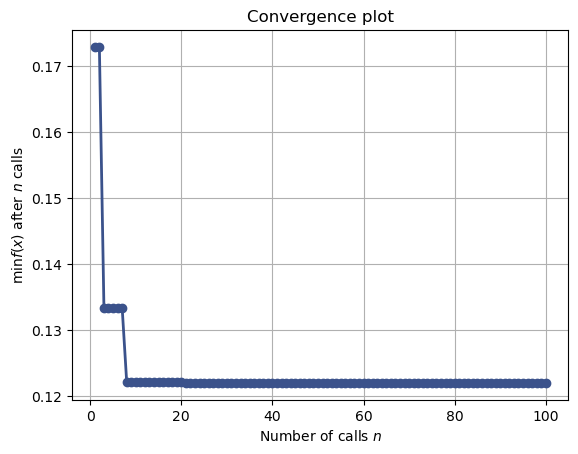

In [92]:
plot_convergence(knr_gp)

<Axes: >

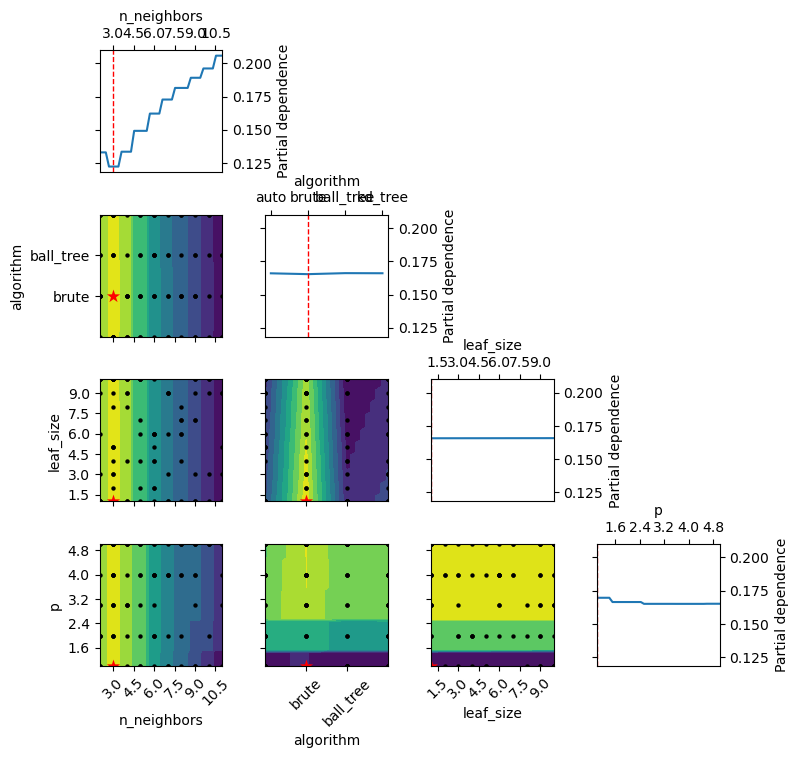

In [93]:
plot_objective(knr_gp)

In [94]:
knr_gp.x

[np.int64(3), np.str_('brute'), np.int64(1), np.int64(1)]

### Optimized hyperparameters

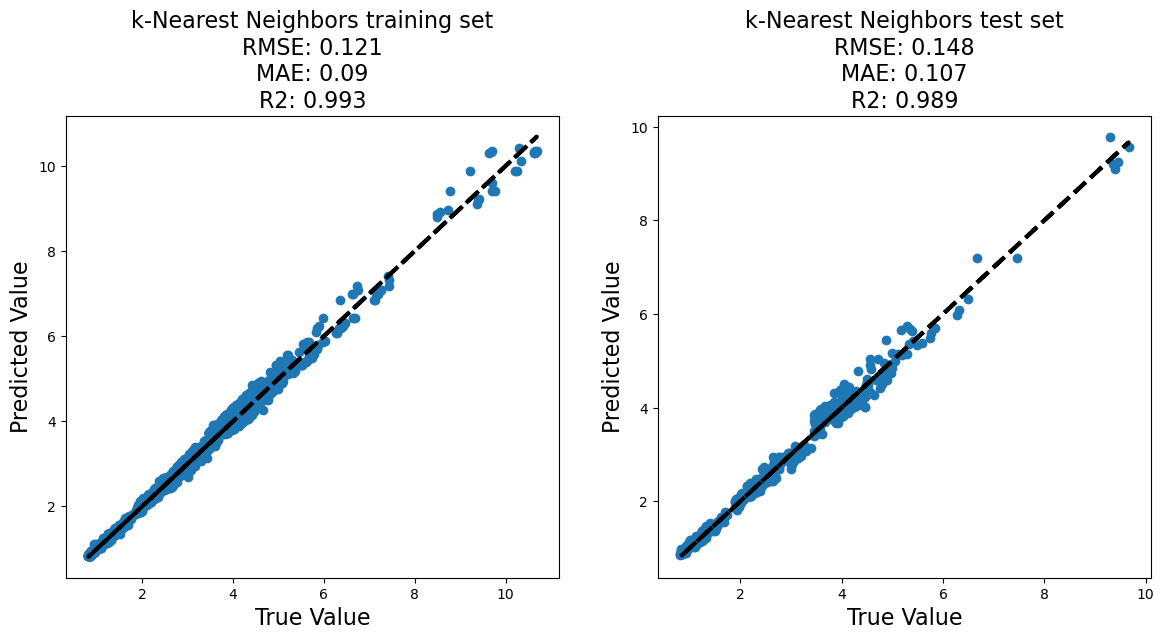

In [95]:
start_time = time.time()

opt_par = [3, 'brute', 10, 1] #knr_gp.x

# use hyper-parameters from optimization
n_neighbors = opt_par[0]
algorithm = opt_par[1]
p = opt_par[2]

#K-Nearest Regression
knregressor = KNeighborsRegressor(n_neighbors=n_neighbors,algorithm=algorithm,p=p)

knregressor.fit(X_train,y_train)
y_pred_train = knregressor.predict(X_train)
y_pred_test = knregressor.predict(X_test)

rmse, mae, R2 = plot('k-Nearest Neighbors', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['k-Nearest Neighbors'] = rmse
mae_scores['k-Nearest Neighbors'] = mae
R2_scores['k-Nearest Neighbors'] = R2

end_time = time.time()
time_reg['k-Nearest Neighbors'] = end_time - start_time

## Support Vector Regression

### Hyperparameter optimization

In [96]:
start_time = time.time()

# Hyperparameter optimization of Support Vector Regressor
svregressor = SVR()

svr_space  = [Categorical(categories=['linear', 'rbf', 'sigmoid'], name='kernel'),
              Real(0.01, 0.5, "log-uniform", name='gamma'),
              Real(1, 5, name='C')]

@use_named_args(svr_space)
def objective(**params):
    svregressor.set_params(**params)
    return -np.mean(cross_val_score(svregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

svr_gp = gp_minimize(objective, svr_space, n_calls=100, n_jobs=-1, random_state=0)

end_time = time.time()
time_hpopt['Support Vector'] = end_time - start_time

D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('linear'), 0.49999999999999994, 5.0] before, using random point ['rbf', 0.01076420630976701, 4.0761194815395605]
  warnings.warn(


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

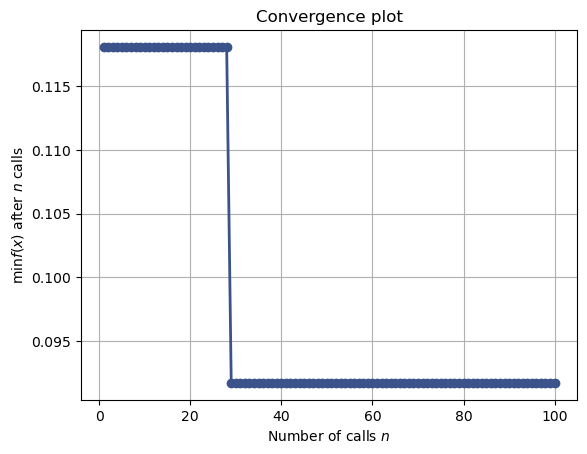

In [97]:
plot_convergence(svr_gp)

<Axes: >

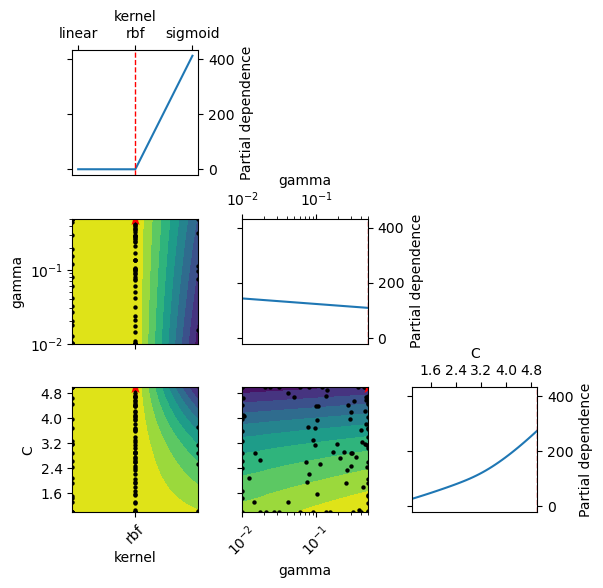

In [98]:
plot_objective(svr_gp)

In [99]:
svr_gp.x

[np.str_('rbf'), 0.49999999999999994, 5.0]

### Optimized hyperparameter

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


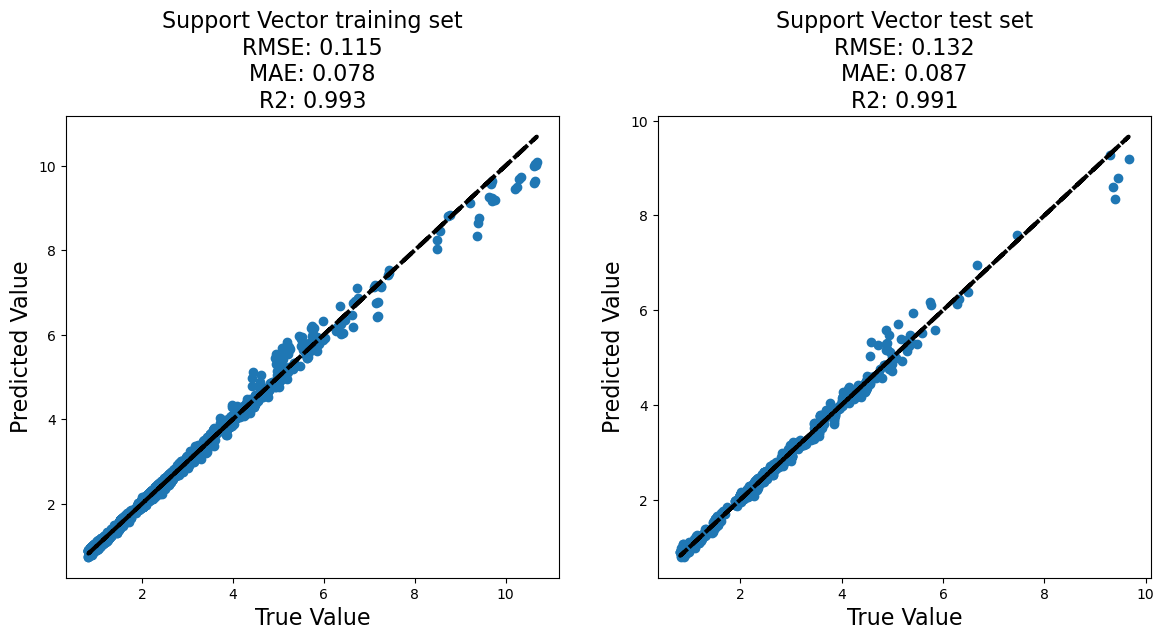

In [100]:
start_time = time.time()

opt_par = ['rbf', 0.49999999999999994, 5.0] #svr_gp.x

# use hyper-parameters from optimization
kernel = opt_par[0]
gamma = opt_par[1]
C = opt_par[2]

# Support Vecotr Regression
svregressor = SVR(kernel=kernel, gamma=gamma, C=C)

svregressor.fit(X_train,y_train)
y_pred_train = svregressor.predict(X_train).reshape(-1, 1)
y_pred_test = svregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Support Vector', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Support Vector'] = rmse
mae_scores['Support Vector'] = mae
R2_scores['Support Vector'] = R2

end_time = time.time()
time_reg['Support Vector'] = end_time - start_time

## Decision Tree Regression

### Hyperparameter optimization

In [101]:
start_time = time.time()

# Hyperparameter optimization of Decision Tree Regressor
dtregressor = DecisionTreeRegressor(random_state=0)

dtr_space  = [Categorical(categories=['squared_error', 'absolute_error', 'friedman_mse'], name='criterion'),
              Categorical(categories=['best', 'random'], name='splitter'),
              Integer(1, 7, name='max_depth')]

@use_named_args(dtr_space)
def objective(**params):
    dtregressor.set_params(**params)
    return -np.mean(cross_val_score(dtregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

dtr_gp = gp_minimize(objective, dtr_space, n_calls=100, n_jobs=-1, random_state=0)

end_time = time.time()
time_hpopt['Decision Tree'] = end_time - start_time

D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('squared_error'), np.str_('best'), np.int64(7)] before, using random point ['squared_error', 'best', np.int64(3)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('squared_error'), np.str_('best'), np.int64(7)] before, using random point ['absolute_error', 'best', np.int64(4)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('squared_error'), np.str_('best'), np.int64(7)] before, using random point ['absolute_error', 'random', np.int64(4)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('squared_error'), np.str_('best'), np.int64(7)] before, using random point ['friedman_mse',

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

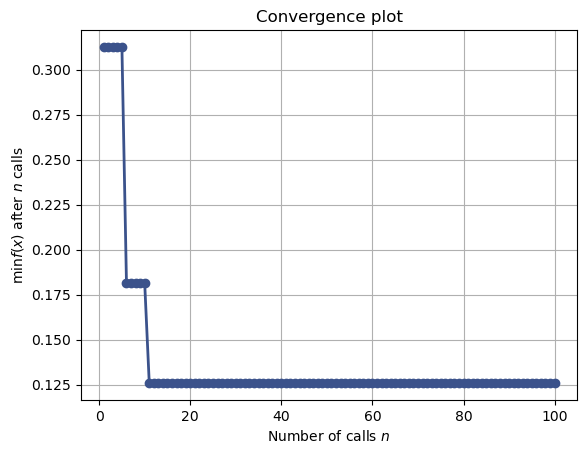

In [102]:
plot_convergence(dtr_gp)

<Axes: >

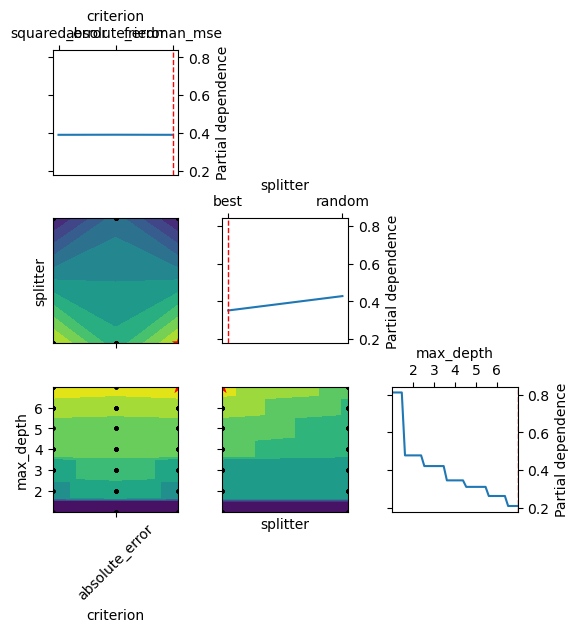

In [103]:
plot_objective(dtr_gp)

In [104]:
dtr_gp.x

[np.str_('friedman_mse'), np.str_('best'), np.int64(7)]

### Optimized hyperparameter

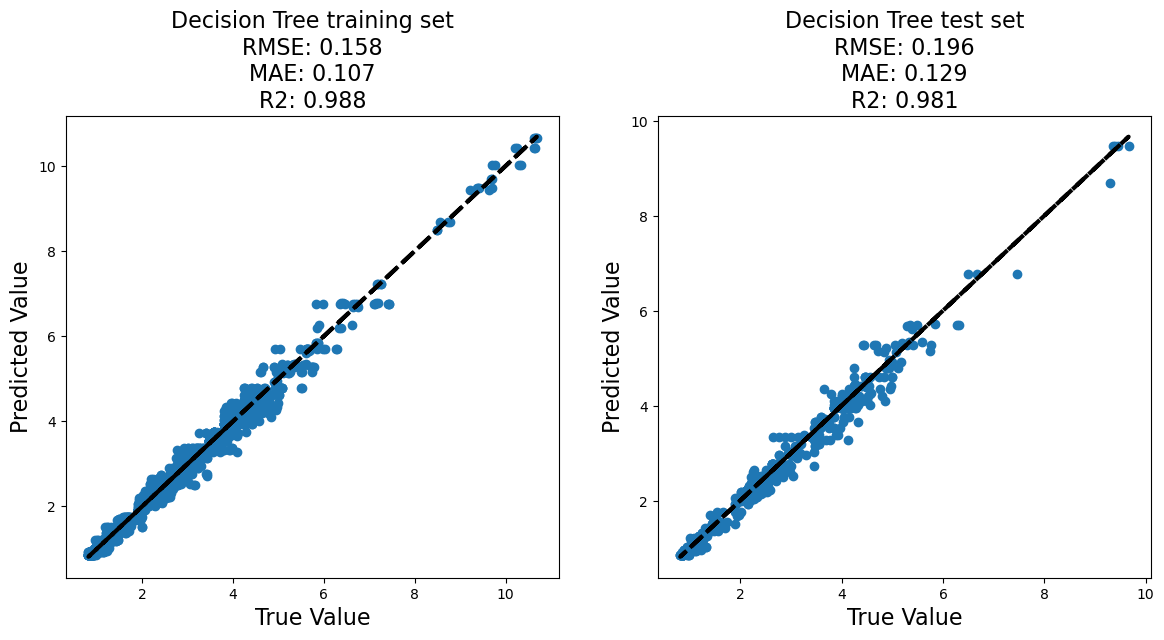

In [105]:
start_time = time.time()

opt_par = ['friedman_mse', 'best', 7] #dtr_gp.x

# use hyper-parameters from optimization
criterion = opt_par[0]
splitter = opt_par[1]
max_depth = opt_par[2]

# Decision Tree Regression
dtregressor = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth, random_state=0)

dtregressor.fit(X_train,y_train)
y_pred_train = dtregressor.predict(X_train).reshape(-1, 1)
y_pred_test = dtregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Decision Tree', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Decision Tree'] = rmse
mae_scores['Decision Tree'] = mae
R2_scores['Decision Tree'] = R2

end_time = time.time()
time_reg['Decision Tree'] = end_time-start_time

## Gradient Boosting Regression

### Hyperparameter optimization

In [106]:
start_time = time.time()

# Hyperparameter optimization of Gradient Boosting Regressor
gbregressor = GradientBoostingRegressor(random_state=0)

gbr_space  = [Real(0.005, 0.9, "log-uniform", name='learning_rate'),
              Categorical(categories=['squared_error', 'absolute_error', 'huber', 'quantile'], name='loss'),
              Integer(1, 3, name='n_estimators'),
              Integer(1, 7, name='max_depth'),
              Real(0.005, 0.9, "log-uniform", name='alpha')]

@use_named_args(gbr_space)
def objective(**params):
    gbregressor.set_params(**params)
    return -np.mean(cross_val_score(gbregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

gbr_gp = gp_minimize(objective, gbr_space, n_calls=100, n_jobs=-1, random_state=0)

end_time = time.time()
time_hpopt['Gradient Boosting'] = end_time-start_time

D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.8999999999999998, np.str_('squared_error'), np.int64(3), np.int64(7), 0.8999999999999998] before, using random point [0.015445803752919875, 'absolute_error', np.int64(3), np.int64(5), 0.4380570405776468]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.8999999999999998, np.str_('squared_error'), np.int64(3), np.int64(7), 0.8999999999999998] before, using random point [0.1441930284313051, 'huber', np.int64(2), np.int64(6), 0.03278130602110787]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.8999999999999998, np.str_('squared_error'), np.int64(3), np.int64(7), 0.8999999999999998] before, using random point [0.005320889708159583, 'huber', np.int64(2), np.int64(5), 0.24605616467371857]
  warn

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

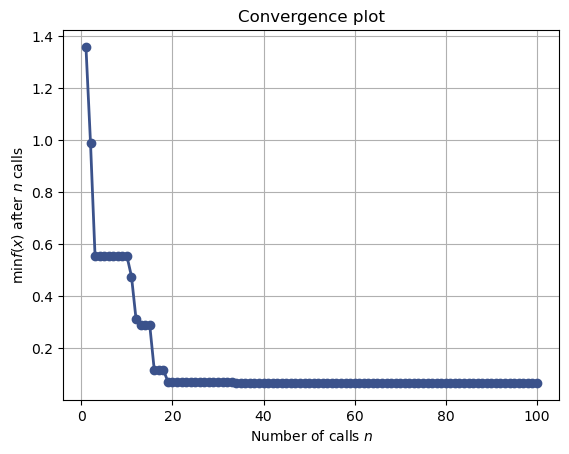

In [107]:
plot_convergence(gbr_gp)

<Axes: >

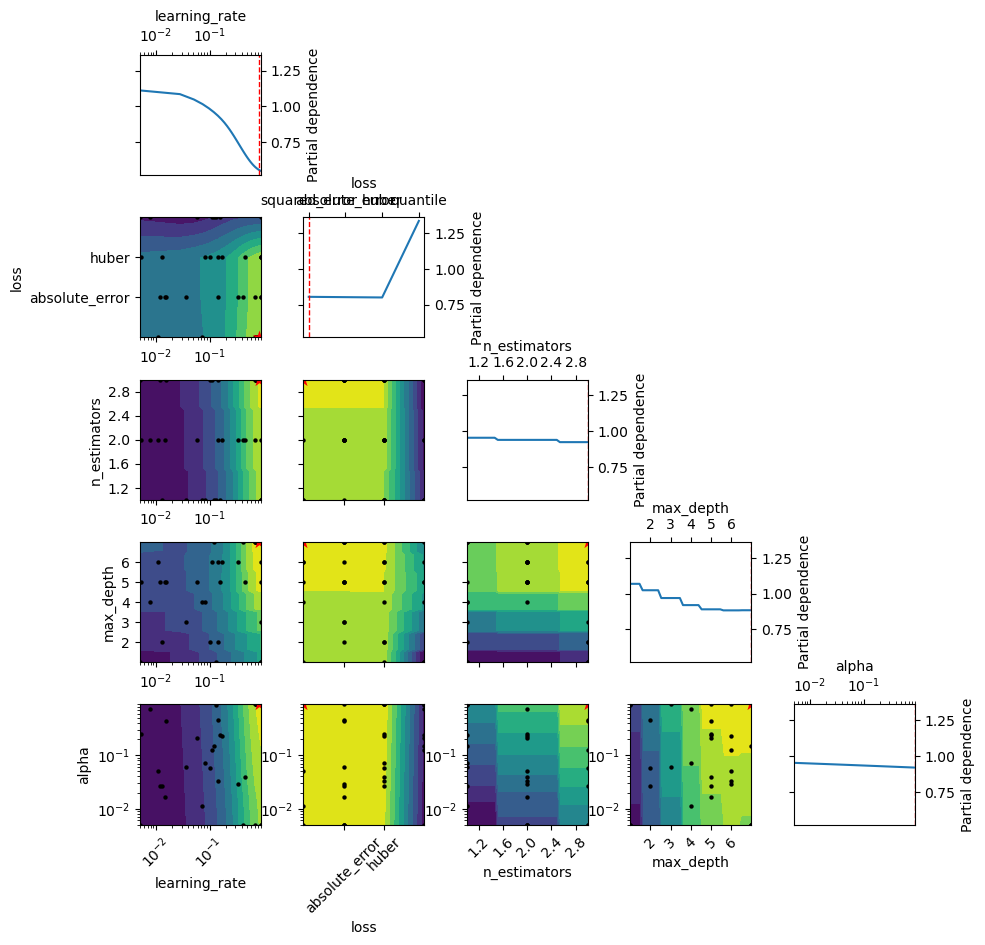

In [108]:
plot_objective(gbr_gp)

In [109]:
gbr_gp.x

[0.8161569580668973,
 np.str_('squared_error'),
 np.int64(3),
 np.int64(7),
 0.8999999999999998]

### Optimized hyperparameter

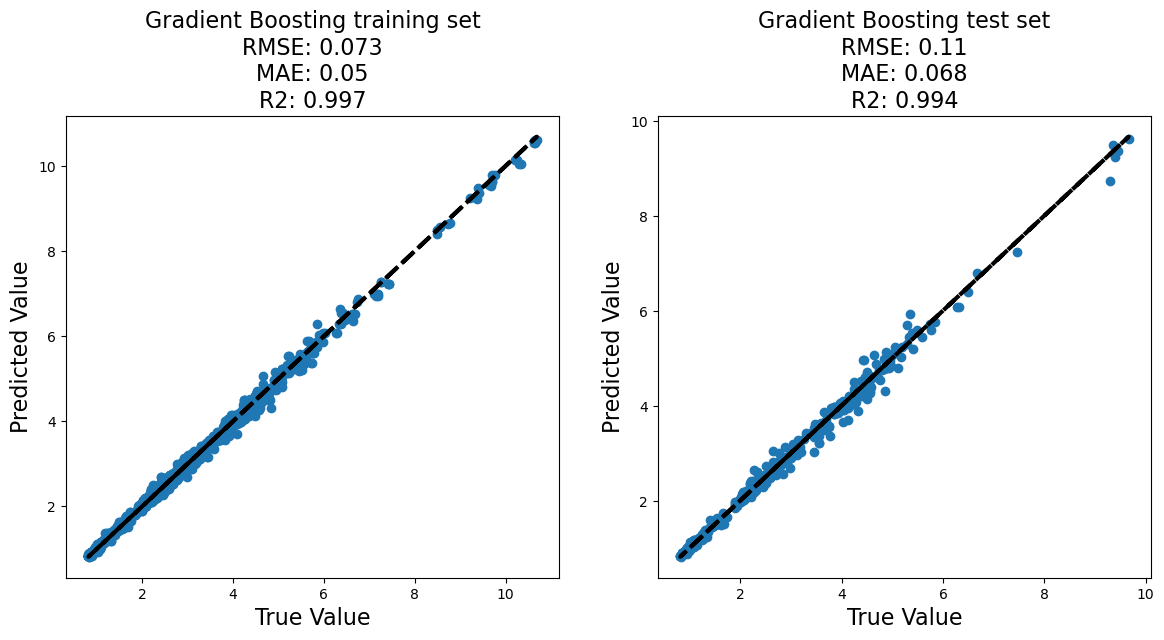

In [110]:
start_time = time.time()

opt_par = [0.7841950873310968, 'squared_error', 3, 7, 0.015101548692479398] #gbr_gp.x

# use hyper-parameters from optimization
learning_rate = opt_par[0]
loss = opt_par[1]
n_estimators = opt_par[2]
max_depth = opt_par[3]
alpha = opt_par[4]

# Gradient Boosting Regression
gbregressor = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate,
                                        max_depth = max_depth, loss = loss, alpha= alpha, random_state=0)

gbregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = gbregressor.predict(X_train).reshape(-1, 1)
y_pred_test = gbregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Gradient Boosting', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Gradient Boosting'] = rmse
mae_scores['Gradient Boosting'] = mae
R2_scores['Gradient Boosting'] = R2

end_time = time.time()
time_reg['Gradient Boosting'] = end_time-start_time

## Random Forest Regression

### Hyperparameter optimization

In [111]:
start_time = time.time()

# Hyperparameter optimization of Random Forest Regressor
rfregressor = RandomForestRegressor(random_state=0)

rfr_space  = [Integer(1, 5, name='n_estimators'),
              Integer(1, 7, name='max_depth')]

@use_named_args(rfr_space)
def objective(**params):
    rfregressor.set_params(**params)
    return -np.mean(cross_val_score(rfregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

rfr_gp = gp_minimize(objective, rfr_space, n_calls=100, n_jobs=-1, random_state=0)

end_time = time.time()
time_hpopt['Random Forest'] = end_time-start_time

D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(7)] before, using random point [np.int64(1), np.int64(6)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(7)] before, using random point [np.int64(4), np.int64(5)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(7)] before, using random point [np.int64(4), np.int64(2)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(7)] before, using random point [np.int64(4), np.int64(5)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5),

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

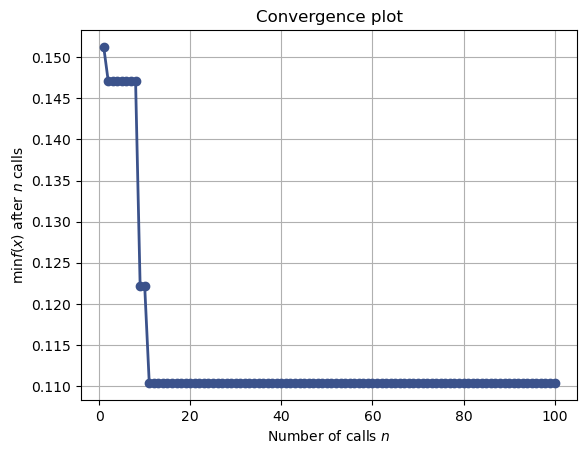

In [112]:
plot_convergence(rfr_gp)

<Axes: >

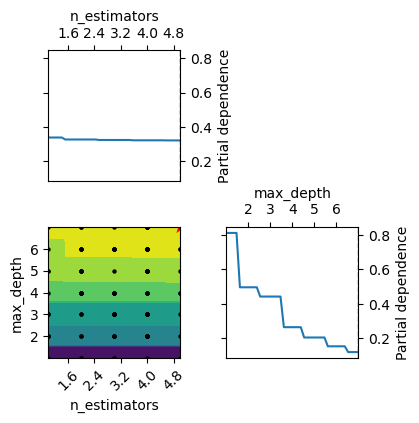

In [113]:
plot_objective(rfr_gp)

In [114]:
rfr_gp.x

[np.int64(5), np.int64(7)]

### Optimized hyperparameter

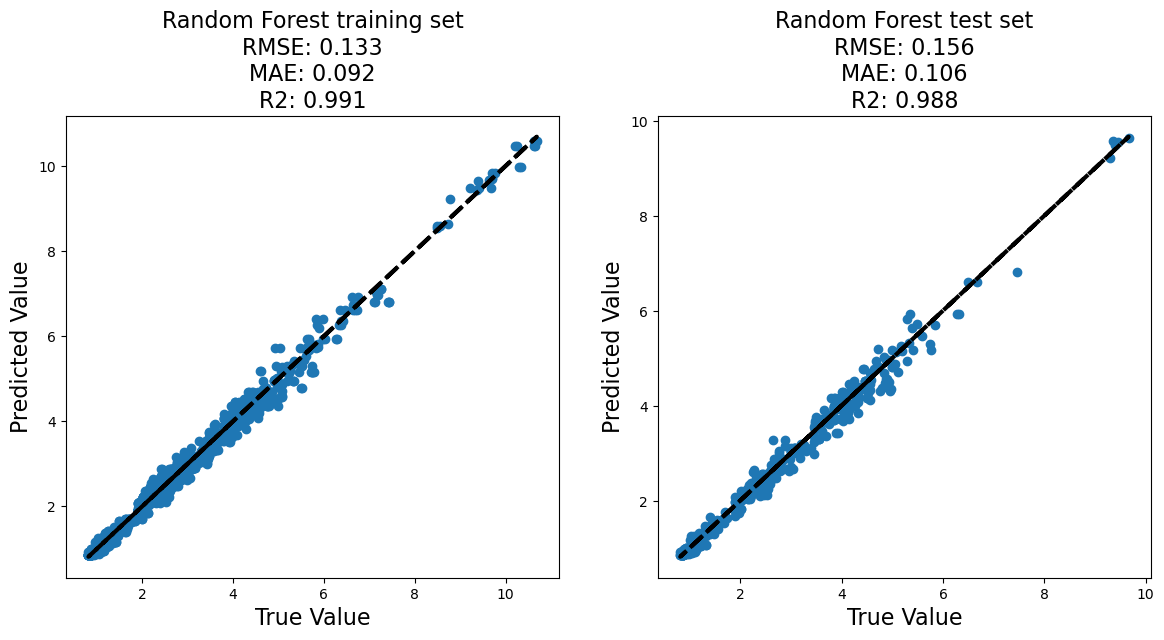

In [115]:
start_time = time.time()

opt_par = [5, 7] #rfr_gp.x

# use hyper-parameters from optimization
n_estimators = opt_par[0]
max_depth = opt_par[1]

# Random Forest Regression
rfregressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

rfregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = rfregressor.predict(X_train).reshape(-1, 1)
y_pred_test = rfregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Random Forest', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Random Forest'] = rmse
mae_scores['Random Forest'] = mae
R2_scores['Random Forest'] = R2

end_time = time.time()
time_reg['Random Forest'] = end_time-start_time

## Extra Trees Regression

### Hyperparameter optimization

In [116]:
start_time = time.time()

etregressor = ExtraTreesRegressor(random_state=0)

etr_space  = [Integer(1, 10, name='n_estimators'),
              Integer(1, 10, name='max_depth')]

@use_named_args(etr_space)
def objective(**params):
    etregressor.set_params(**params)
    return -np.mean(cross_val_score(etregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

etr_gp = gp_minimize(objective, etr_space, n_calls=100, n_jobs=-1, random_state=0)

end_time = time.time()
time_hpopt['Extra Trees'] = end_time-start_time

D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(10), np.int64(10)] before, using random point [np.int64(8), np.int64(8)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(10), np.int64(10)] before, using random point [np.int64(3), np.int64(10)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(10), np.int64(10)] before, using random point [np.int64(8), np.int64(7)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(10), np.int64(10)] before, using random point [np.int64(8), np.int64(4)]
  warnings.warn(
D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

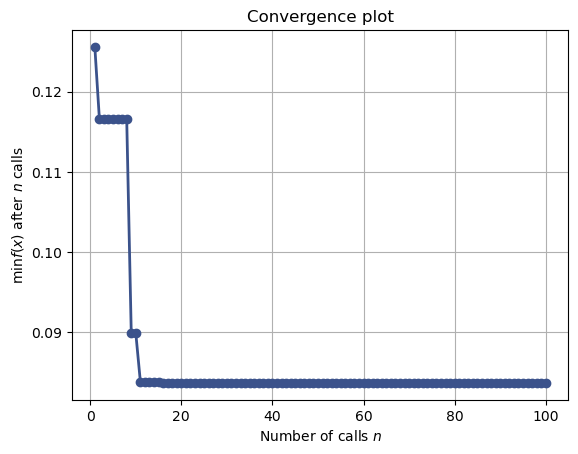

In [117]:
plot_convergence(etr_gp)

<Axes: >

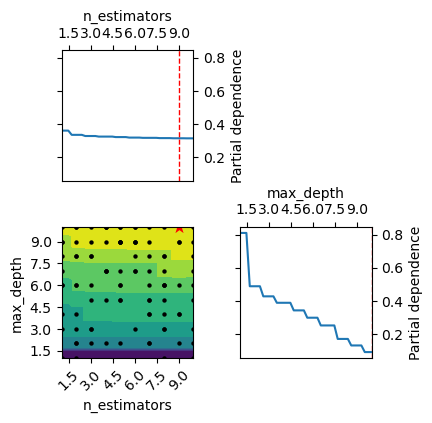

In [118]:
plot_objective(etr_gp)

In [119]:
etr_gp.x

[np.int64(9), np.int64(10)]

### Optimized hyperparameter

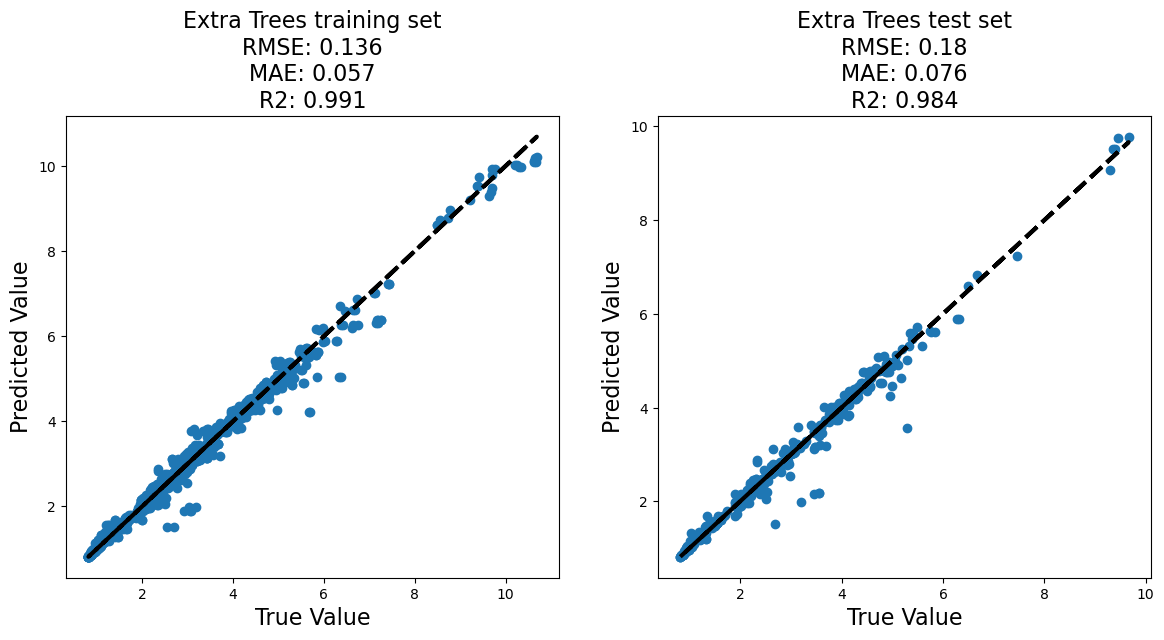

In [120]:
start_time = time.time()

opt_par = [9, 10] #etr_gp.x

# use hyper-parameters from optimization
n_estimators = opt_par[0]
max_depth = opt_par[1]

# Extra Trees Regression
etregressor = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

etregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = etregressor.predict(X_train).reshape(-1, 1)
y_pred_test = etregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Extra Trees', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Extra Trees'] = rmse
mae_scores['Extra Trees'] = mae
R2_scores['Extra Trees'] = R2

end_time = time.time()
time_reg['Extra Trees'] = end_time-start_time

## XGBoost Regression

### Hyperparameter optimization

In [121]:
start_time = time.time()

xgbregressor = XGBRegressor(random_state=0)

xgbr_space  = [Real(0.005, 1, "log-uniform", name='eta'),
              Integer(1, 5, name='n_estimators'),
              Integer(1, 7, name='max_depth'),
              Real(0.1, 0.9, "log-uniform", name='subsample'),
              Real(0.005, 0.9, "log-uniform", name='colsample_bytree')]

@use_named_args(xgbr_space)
def objective(**params):
    xgbregressor.set_params(**params)
    return -np.mean(cross_val_score(xgbregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

xgbr_gp = gp_minimize(objective, xgbr_space, n_calls=100, n_jobs=-1, random_state=0)

end_time = time.time()
time_hpopt['XG Boost'] = end_time-start_time

D:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(5), np.int64(7), 0.9, 0.8999999999999998] before, using random point [0.10816376148727966, np.int64(4), np.int64(2), 0.7245796241037533, 0.17294433823637675]
  warnings.warn(


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

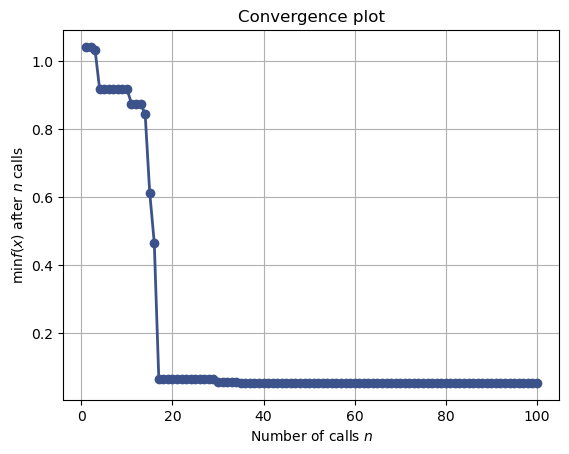

In [122]:
plot_convergence(xgbr_gp)

<Axes: >

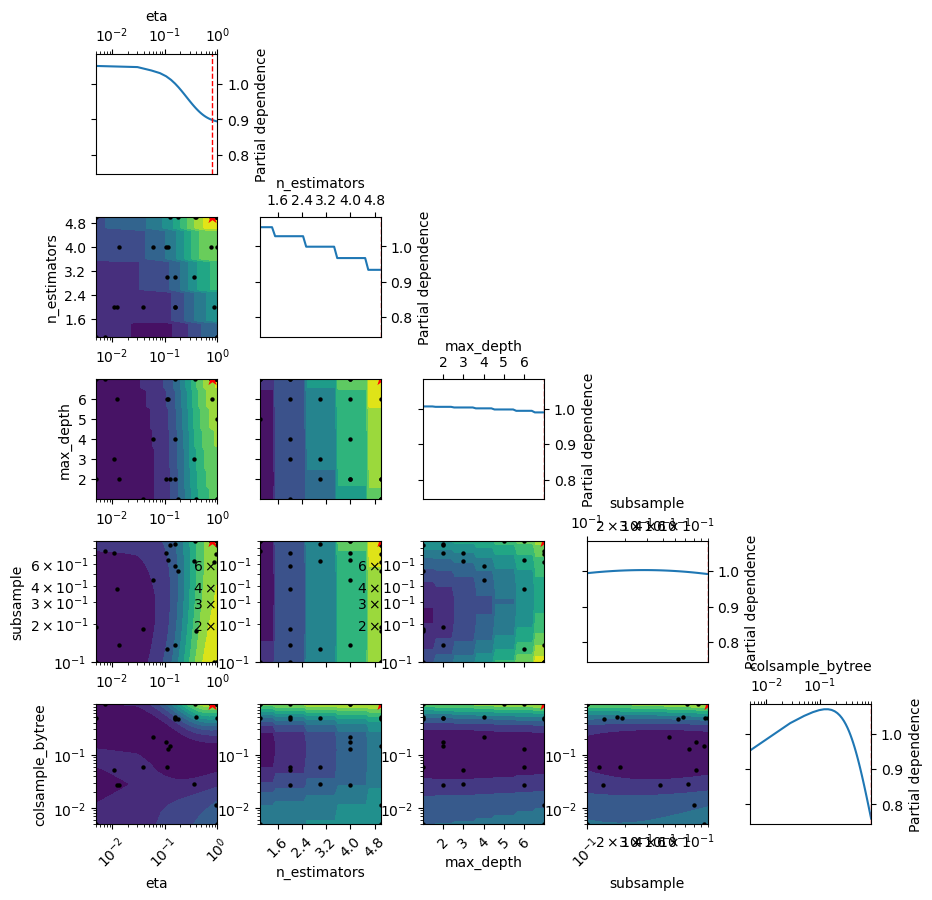

In [123]:
plot_objective(xgbr_gp)

In [124]:
xgbr_gp.x

[0.7869416705082785, np.int64(5), np.int64(7), 0.9, 0.8999999999999998]

### Optimized hyperparameter

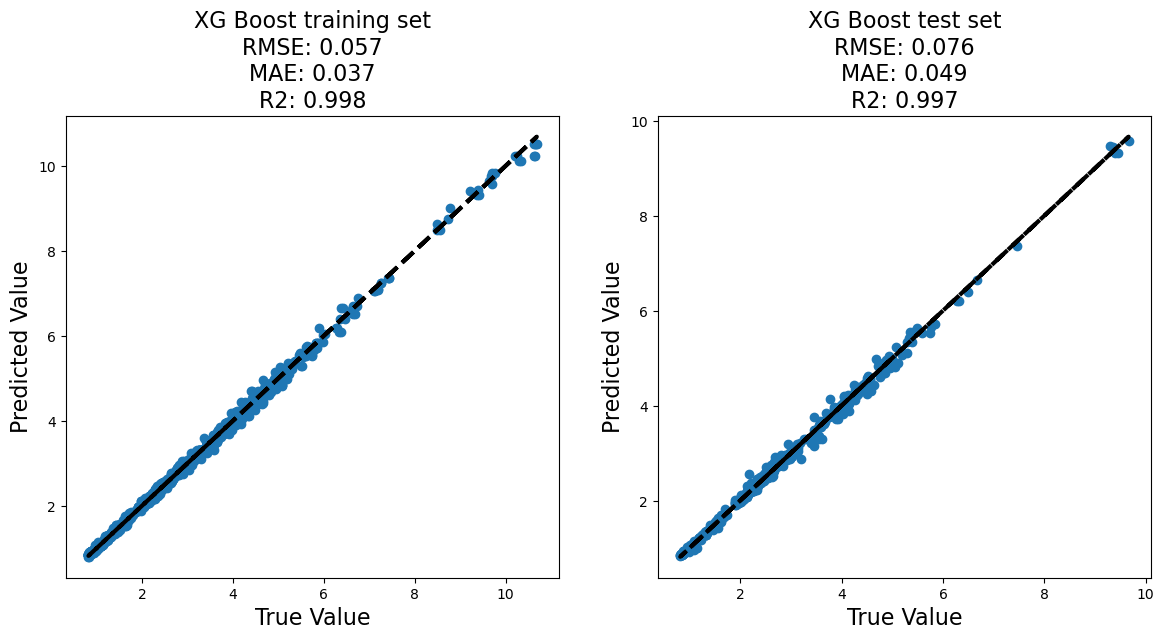

In [125]:
start_time = time.time()

opt_par = [0.7449664006975826, 5, 7, 0.9, 0.8999999999999998] #xgbr_gp.x

# use hyper-parameters from optimization
eta= opt_par[0]
n_estimators = opt_par[1]
max_depth = opt_par[2]
subsample = opt_par[3]
colsample_bytree = opt_par[4]

#XGBoost Regression
xgbregressor = XGBRegressor(eta=eta, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample,
                            colsample_bytree=colsample_bytree, random_state=0)

xgbregressor.fit(X_train,y_train)
y_pred_train = xgbregressor.predict(X_train).reshape(-1, 1)
y_pred_test = xgbregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('XG Boost', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['XG Boost'] = rmse
mae_scores['XG Boost'] = mae
R2_scores['XG Boost'] = R2

end_time = time.time()
time_reg['XG Boost'] = end_time-start_time

## Feature importance

In [126]:
# defining feature importance function
def feature_importance(regr, features, title):

    # getting the feature importance
    feature_importance = regr.feature_importances_
    # make importances relative to max importance by sorting from max to min
    sorted_idx = feature_importance.argsort()
    feature_importance_n = 100.0 * (feature_importance[sorted_idx] / sum(feature_importance))

    plt.barh(features[sorted_idx], feature_importance_n)
    plt.xticks(fontsize=10)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()

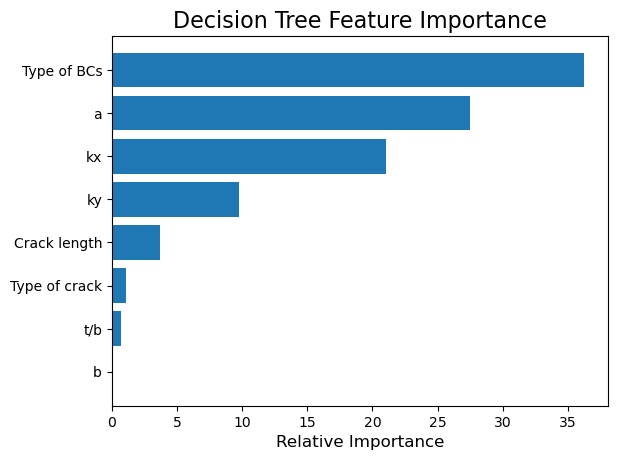

In [127]:
feature_importance(dtregressor, features, 'Decision Tree Feature Importance')

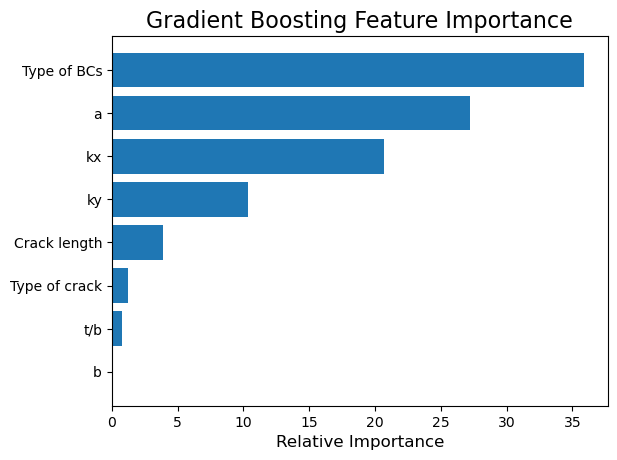

In [128]:
feature_importance(gbregressor, features, 'Gradient Boosting Feature Importance')

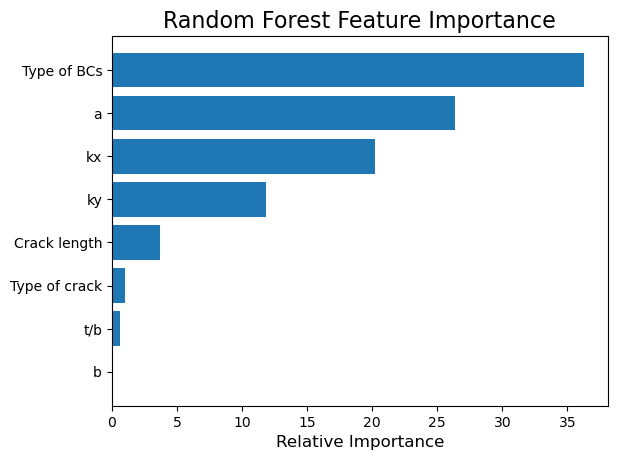

In [129]:
feature_importance(rfregressor, features, 'Random Forest Feature Importance')

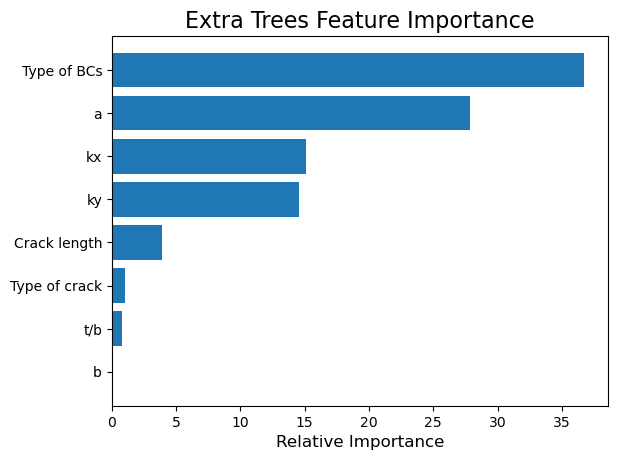

In [130]:
feature_importance(etregressor, features, 'Extra Trees Feature Importance')

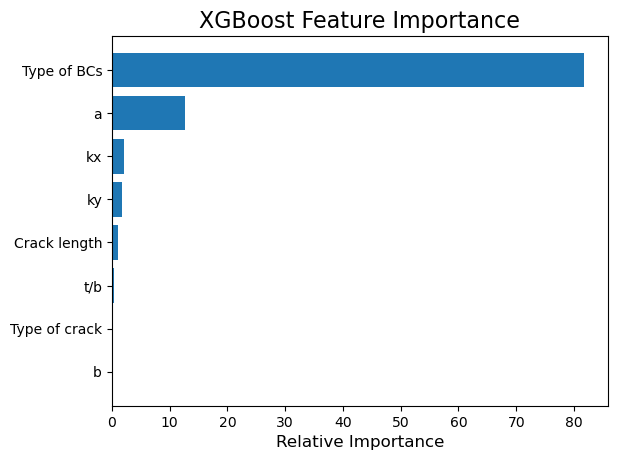

In [131]:
feature_importance(xgbregressor, features, 'XGBoost Feature Importance')

## Permutation importance (feature)

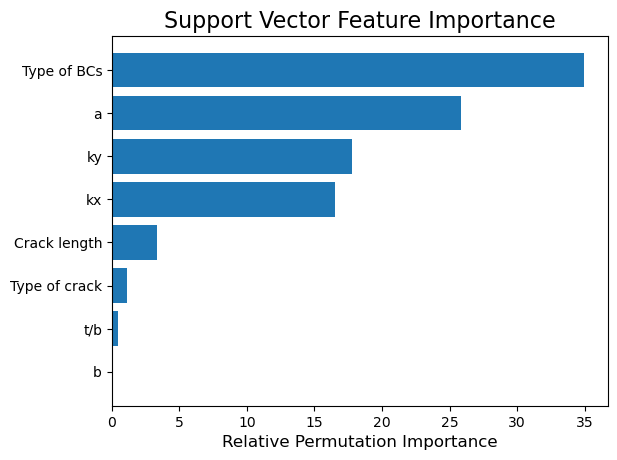

In [132]:
from sklearn.inspection import permutation_importance

perm_imp  =  permutation_importance(svregressor, X_test,  y_test)

sorted_idx = perm_imp.importances_mean.argsort()
perm_imp_n = 100.0 * (perm_imp.importances_mean[sorted_idx] / sum(perm_imp.importances_mean))
plt.barh(features[sorted_idx], perm_imp_n)
plt.xlabel("Relative Permutation Importance", fontsize = 12)
plt.title('Support Vector Feature Importance', fontsize=16)
plt.show()

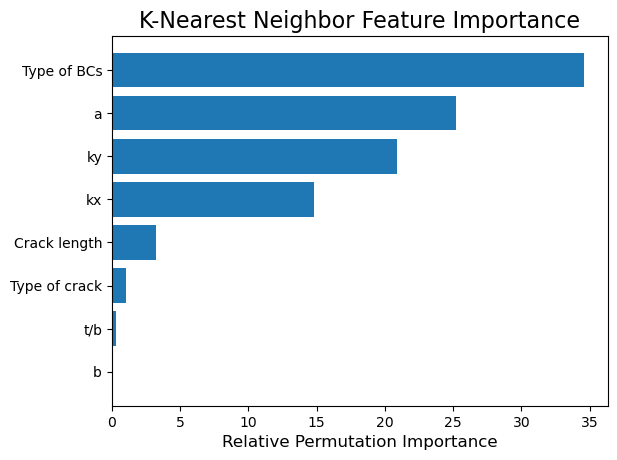

In [133]:
perm_imp  =  permutation_importance(knregressor, X_test,  y_test)

sorted_idx = perm_imp.importances_mean.argsort()
perm_imp_n = 100.0 * (perm_imp.importances_mean[sorted_idx] / sum(perm_imp.importances_mean))
plt.barh(features[sorted_idx], perm_imp_n)
plt.xlabel("Relative Permutation Importance", fontsize = 12)
plt.title('K-Nearest Neighbor Feature Importance', fontsize=16)
plt.show()

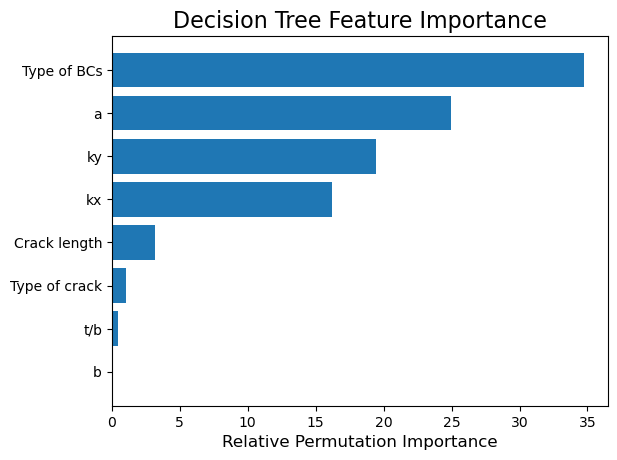

In [134]:
perm_imp  =  permutation_importance(dtregressor, X_test,  y_test)

sorted_idx = perm_imp.importances_mean.argsort()
perm_imp_n = 100.0 * (perm_imp.importances_mean[sorted_idx] / sum(perm_imp.importances_mean))
plt.barh(features[sorted_idx], perm_imp_n)
plt.xlabel("Relative Permutation Importance", fontsize = 12)
plt.title('Decision Tree Feature Importance', fontsize=16)
plt.show()

## Neural Network Regression

In [135]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,CSVLogger
from scikeras.wrappers import KerasRegressor
import os

### 3 hidden layer architecture

In [136]:
start_time = time.time()

def model():
    K.clear_session()
    # building network
    regression = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ], name='omega_prediction_model_3layer')
    optimizer = Adam(learning_rate=1e-4)
    regression.compile(optimizer=optimizer, loss='mae')
    return regression

In [137]:
nn3layer = model()
nn3layer.summary()

D:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "omega_prediction_model_3layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,521 (170.00 KB)

 Trainable params: 43,521 (170.00 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
# Training with callback

# Create file path for CSVLogger
current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'training_log.csv')
with open(file_path, 'w') as f:
    pass

# Define the callbacks
CSV = CSVLogger('training_log.csv')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=5, min_lr=1e-6)

# Wrap the Keras model with KerasRegressor
nn3 = model()   # build your model

nn3.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    callbacks=[CSV, reduce_lr],
    validation_data=(X_test, y_test)
)


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1986 - val_loss: 1.7572 - learning_rate: 1.0000e-04
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4723 - val_loss: 1.2440 - learning_rate: 1.0000e-04
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1054 - val_loss: 1.0669 - learning_rate: 1.0000e-04
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0058 - val_loss: 0.9635 - learning_rate: 1.0000e-04
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9217 - val_loss: 0.8489 - learning_rate: 1.0000e-04
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7958 - val_loss: 0.7141 - learning_rate: 1.0000e-04
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6705 - val_loss: 0.5977 - learning_rate: 1.0000e-04
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5724 - val_loss: 0.5157 - learning_rate: 1.0000e-04
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4977 - val_loss: 0.4233 - learning_

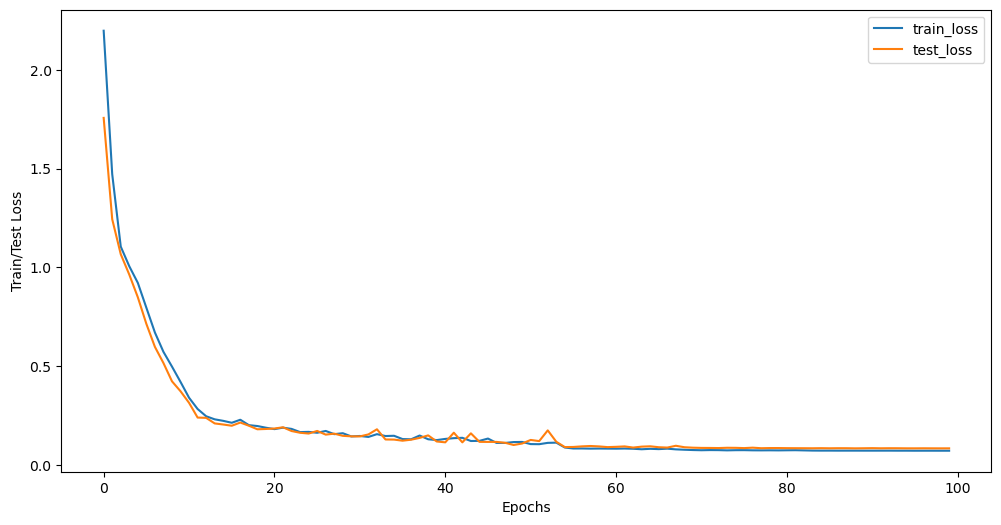

In [139]:
loss_df = pd.read_csv('training_log.csv')
plt.figure(figsize=(12, 6))
plt.plot(loss_df['epoch'],loss_df['loss'])
plt.plot(loss_df['epoch'],loss_df['val_loss'])

plt.xlabel("Epochs")
plt.ylabel("Train/Test Loss")
plt.legend(['train_loss','test_loss'])
plt.show()

In [140]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=nn3_model.predict(X_train)
y_pred_test=nn3_model.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Neural Network_3 layer', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['NN_3 layer'] = rmse
mae_scores['NN_3 layer'] = mae
R2_scores['NN_3 layer'] = R2

end_time = time.time()
time_reg['NN_3layer'] = end_time-start_time

NameError: name 'nn3_model' is not defined

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


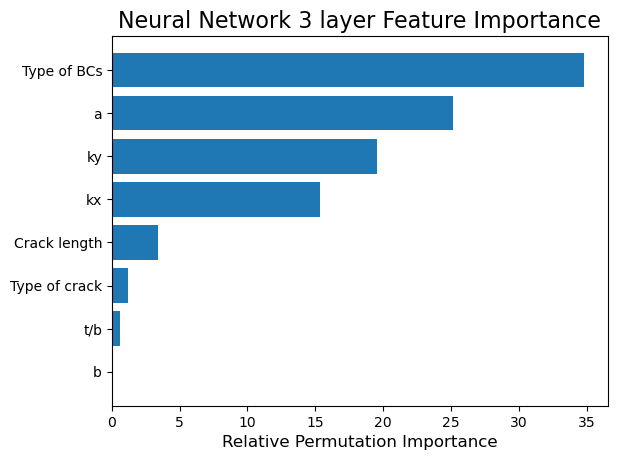

In [209]:
perm_imp  =  permutation_importance(nn3_model, X_test,  y_test)

sorted_idx = perm_imp.importances_mean.argsort()
perm_imp_n = 100.0 * (perm_imp.importances_mean[sorted_idx] / sum(perm_imp.importances_mean))
plt.barh(features[sorted_idx], perm_imp_n)
plt.xlabel("Relative Permutation Importance", fontsize = 12)
plt.title('Neural Network 3 layer Feature Importance', fontsize=16)
plt.show()

### 4 hidden layer architecture

In [210]:
start_time = time.time()

def model2():
    K.clear_session()
    # building network
    regression = keras.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ], name='omega_prediction_model_4layer')
    optimizer = Adam(learning_rate=1e-4)
    regression.compile(optimizer=optimizer, loss='mae')
    return regression

In [211]:
nn4layer = model2()
nn4layer.summary()

D:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "omega_prediction_model_4layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,153 (692.00 KB)

 Trainable params: 177,153 (692.00 KB)

 Non-trainable params: 0 (0.00 B)

In [212]:
# Training with callback

# Define the callbacks
CSV = CSVLogger('training_log.csv')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=5, min_lr=1e-6)

# Wrap the Keras model with KerasRegressor
nn4_model = KerasRegressor(build_fn=model2, epochs=100, batch_size=32)
nn4_model.fit(X_train,y_train, callbacks=[CSV,reduce_lr],validation_split=0.0,
             validation_data=(X_test,y_test))

Epoch 1/100


D:\Anaconda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
D:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9759 - val_loss: 1.6423
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2864 - val_loss: 1.1490
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0412 - val_loss: 0.9728
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8853 - val_loss: 0.7485
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816 - val_loss: 0.5889
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4914 - val_loss: 0.4559
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3883 - val_loss: 0.2843
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3311 - val_loss: 0.4682
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2948 - val_loss: 0.3189
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3383 - val_loss: 0.2593
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2357 - val_loss: 0.2496
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2527 - val_lo

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

KerasRegressor(
	model=None
	build_fn=<function model2 at 0x0000017806A9BB00>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

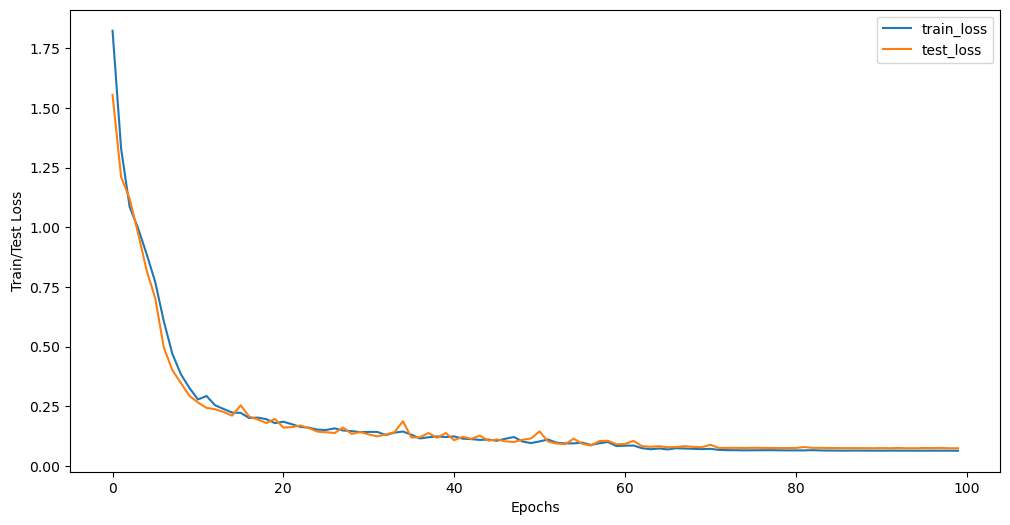

In [213]:
loss_df = pd.read_csv('training_log.csv')
aa=0
plt.figure(figsize=(12, 6))
plt.plot(loss_df['epoch'],loss_df['loss'])
plt.plot(loss_df['epoch'],loss_df['val_loss'])

plt.xlabel("Epochs")
plt.ylabel("Train/Test Loss")
plt.legend(['train_loss','test_loss'])
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


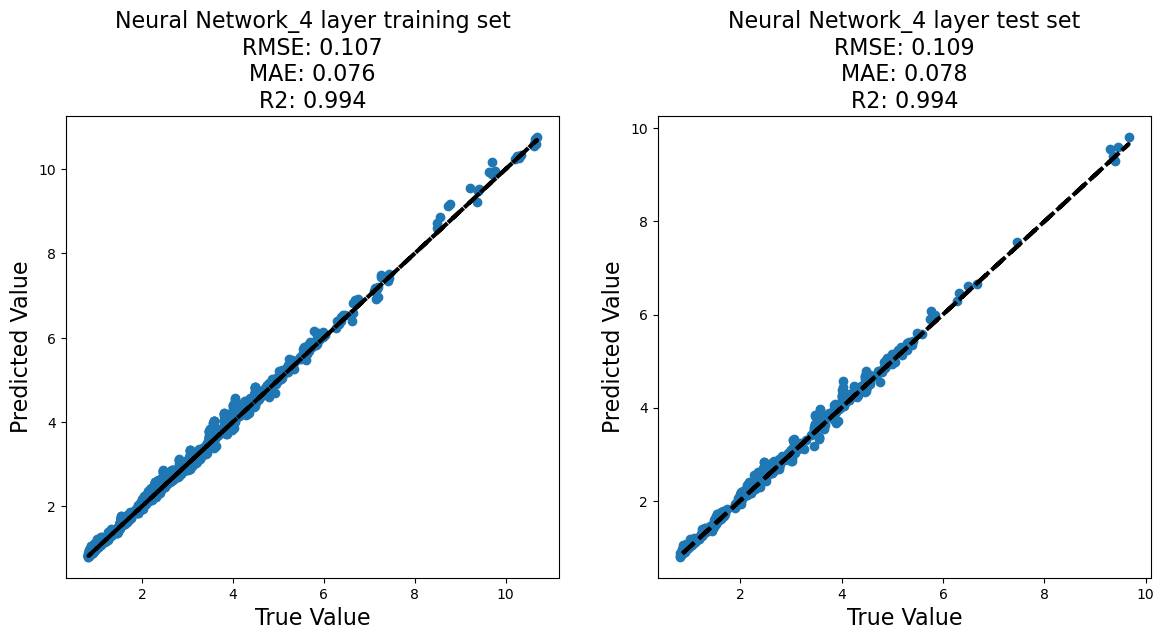

In [214]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=nn4_model.predict(X_train)
y_pred_test=nn4_model.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Neural Network_4 layer', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['NN_4 layer'] = rmse
mae_scores['NN_4 layer'] = mae
R2_scores['NN_4 layer'] = R2

end_time = time.time()
time_reg['NN_4 layer'] = end_time-start_time

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


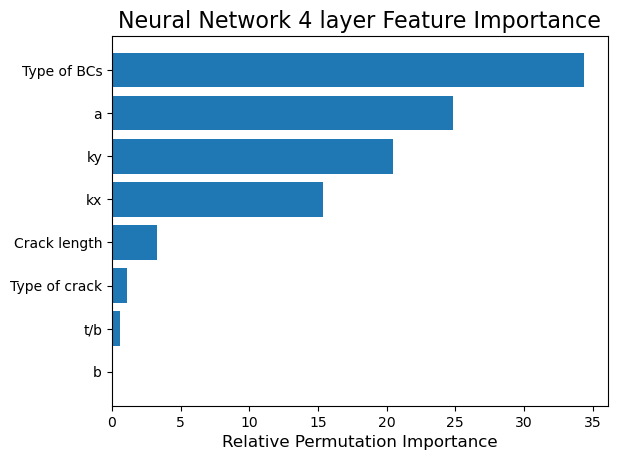

In [215]:
perm_imp  =  permutation_importance(nn4_model, X_test,  y_test)

sorted_idx = perm_imp.importances_mean.argsort()
perm_imp_n = 100.0 * (perm_imp.importances_mean[sorted_idx] / sum(perm_imp.importances_mean))
plt.barh(features[sorted_idx], perm_imp_n)
plt.xlabel("Relative Permutation Importance", fontsize = 12)
plt.title('Neural Network 4 layer Feature Importance', fontsize=16)
plt.show()

## All ML models performance

In [216]:
rmse = pd.DataFrame(list(rmse_scores.items()),columns = ['Regressor','RMSE'])
mae = pd.DataFrame(list(mae_scores.items()),columns = ['Regressor','MAE'])
r2 = pd.DataFrame(list(R2_scores.items()),columns = ['Regressor','R2'])
scores_df = pd.concat([rmse,mae.iloc[:,1],r2.iloc[:,1]],axis=1)
scores_df

,Regressor,RMSE,MAE,R2
0,Linear,0.729,0.416,0.732
1,Ridge,0.729,0.416,0.732
2,Lasso,0.729,0.416,0.732
3,k-Nearest Neighbors,0.148,0.107,0.989
4,Support Vector,0.132,0.087,0.991
5,Decision Tree,0.196,0.129,0.981
6,Gradient Boosting,0.110,0.068,0.994
7,Random Forest,0.156,0.106,0.988
8,Extra Trees,0.180,0.076,0.984
9,XG Boost,0.076,0.049,0.997


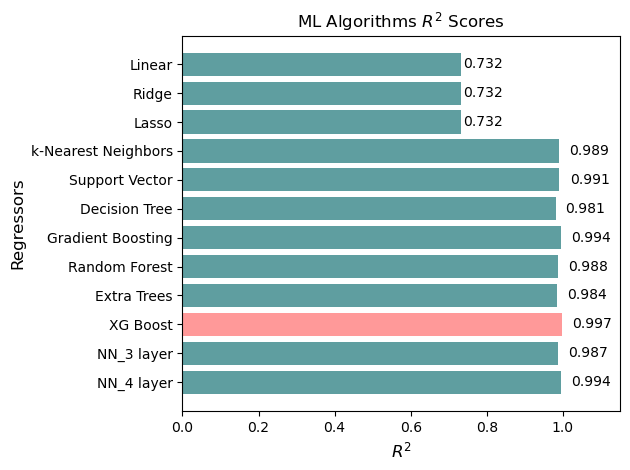

In [217]:
# Plotting R2 of all ML models

fig = plt.figure()
ax = fig.add_subplot(111)

performance = list(R2_scores.values())

bar = ax.barh(range(len(R2_scores.values())),performance,
              tick_label=list(R2_scores.keys()),color=np.where(performance == max(performance),'#ff9999','cadetblue'))
ax.set_ylabel('Regressors', fontsize=12)
ax.set_xlabel('$R^2$', fontsize=12)
ax.set_title('ML Algorithms $R^2$ Scores')
ax.invert_yaxis()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        plt.text(1.08*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                 '%.3f' % width,
                 ha='center', va='center',fontsize=10)
autolabel(bar)

ax.set_xlim(0,1.15)

fig.tight_layout()
plt.show()

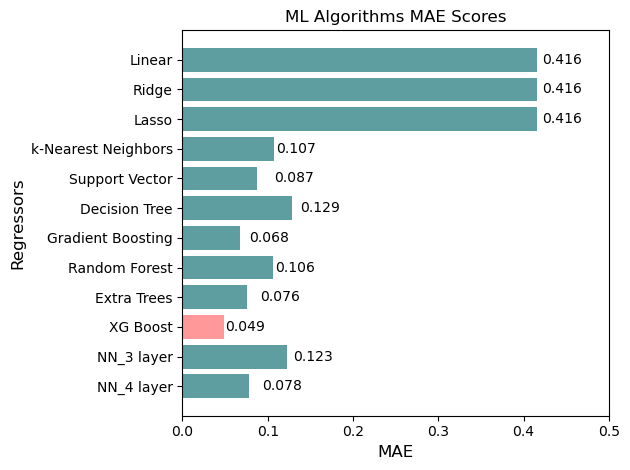

In [218]:
# Plotting MAE of all ML models

fig = plt.figure()
ax = fig.add_subplot(111)

performance = list(mae_scores.values())

bar = ax.barh(range(len(mae_scores.values())),performance,
              tick_label=list(mae_scores.keys()),color=np.where(performance == min(performance),'#ff9999','cadetblue'))
ax.set_ylabel('Regressors', fontsize=12)
ax.set_xlabel('MAE', fontsize=12)
ax.set_title('ML Algorithms MAE Scores')
ax.invert_yaxis()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        if width >= 0.3:
          plt.text(1.07*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                   '%.3f' % width, ha='center', va='center',fontsize=10)
        elif width >= 0.2 and width < 0.3:
            plt.text(1.13*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
        elif width >= 0.1 and width < 0.2:
            plt.text(1.25*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
        else:
            plt.text(1.5*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
autolabel(bar)

ax.set_xlim(0,0.5)

fig.tight_layout()
plt.show()

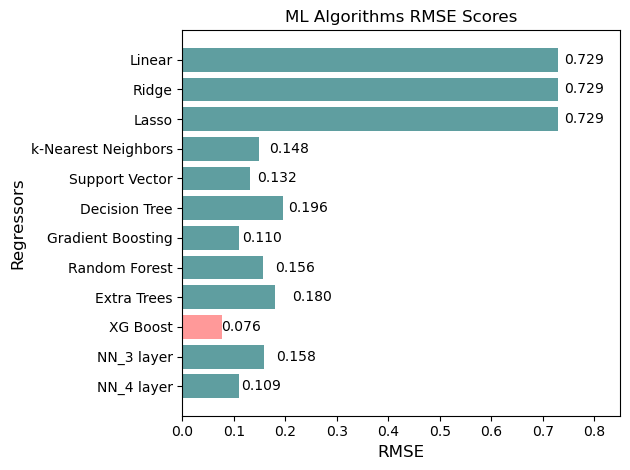

In [219]:
# Plotting RMSE of all ML models

fig = plt.figure()
ax = fig.add_subplot(111)

performance = list(rmse_scores.values())

bar = ax.barh(range(len(rmse_scores.values())),performance,
              tick_label=list(rmse_scores.keys()),color=np.where(performance == min(performance),'#ff9999','cadetblue'))
ax.set_ylabel('Regressors', fontsize=12)
ax.set_xlabel('RMSE', fontsize=12)
ax.set_title('ML Algorithms RMSE Scores')
ax.invert_yaxis()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        if width >= 0.7:
          plt.text(1.07*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                   '%.3f' % width, ha='center', va='center',fontsize=10)
        elif width >= 0.6 and width < 0.7:
            plt.text(1.08*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
        elif width >= 0.4 and width < 0.5:
            plt.text(1.12*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
        elif width >= 0.3 and width < 0.4:
            plt.text(1.15*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
        elif width >= 0.196 and width < 0.3:
            plt.text(1.25*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
        elif width >= 0.1 and width < 0.2:
            plt.text(1.4*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
        else:
            plt.text(1.5*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                    '%.3f' % width, ha='center', va='center',fontsize=10)
autolabel(bar)

ax.set_xlim(0,0.85)

fig.tight_layout()
plt.show()

In [220]:
scores_df.to_excel('Scores_Omega.xlsx')

## Computation time for hyperparameter optimization

In [221]:
t_ho = pd.DataFrame(list(time_hpopt.items()),columns = ['Regressor','Time (s)'])
t_ho

,Regressor,Time (s)
0,Ridge,0.009483
1,Lasso,0.039046
2,k-Nearest Neighbors,43.952891
3,Support Vector,182.992568
4,Decision Tree,35.654741
5,Gradient Boosting,41.831793
6,Random Forest,31.642115
7,Extra Trees,31.403630
8,XG Boost,34.788401


In [222]:
def wrap_labels (ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

C:\Users\zero\AppData\Local\Temp\ipykernel_5676\1898720775.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


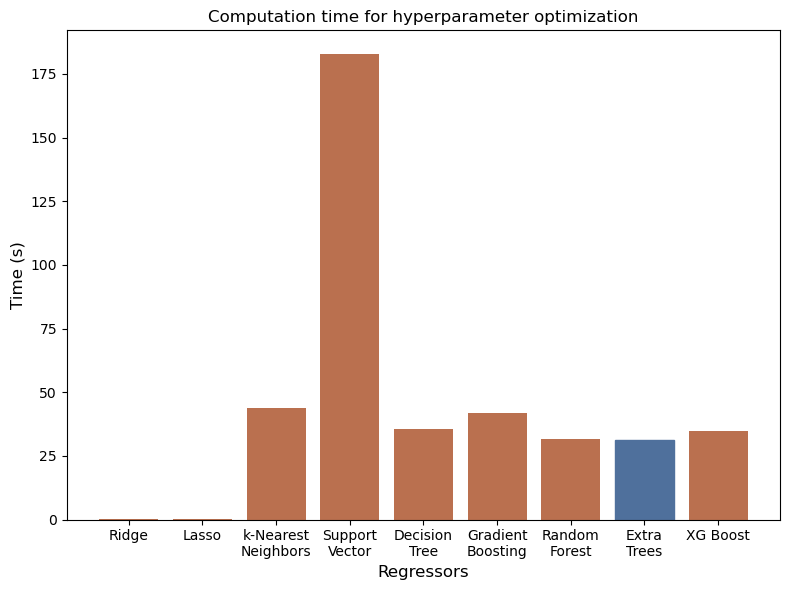

In [223]:
# Plotting computation time for hyperparameter optimization of  all ML models

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

performance = list(t_ho.iloc[:,1])
titles = list(t_ho.iloc[:,0])

bars = ax.bar(titles, performance,color='#BA704F')

# Get the third lowest value
third_lowest = sorted(performance)[2]

# Color the third lowest bar red
for i, bar in enumerate(bars):
    if performance[i] == third_lowest:
        bar.set_color('#4F709C')

ax.set_xlabel('Regressors', fontsize=12)
ax.set_ylabel('Time (s)', fontsize=12)
ax.set_title('Computation time for hyperparameter optimization')
wrap_labels(ax,10)

fig.tight_layout()
plt.show()

In [224]:
t_ho.to_excel('Time_HO.xlsx')

## Computation time for building ML models

In [225]:
t_build = pd.DataFrame(list(time_reg.items()),columns = ['Regressor','Time (s)'])
t_build

,Regressor,Time (s)
0,Linear,0.165571
1,Ridge,0.160122
2,Lasso,0.161458
3,k-Nearest Neighbors,0.351390
4,Support Vector,0.455715
5,Decision Tree,0.182851
6,Gradient Boosting,0.169441
7,Random Forest,0.174803
8,Extra Trees,0.166608
9,XG Boost,0.174708


C:\Users\zero\AppData\Local\Temp\ipykernel_5676\1898720775.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


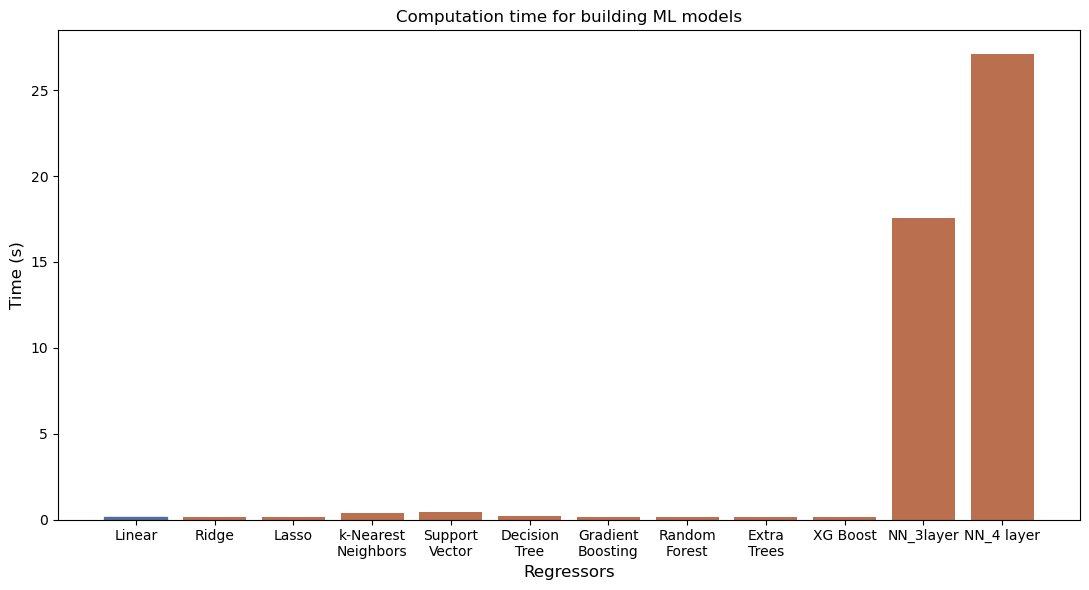

In [226]:
# Plotting computation time for building all ML models

fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)

performance = list(t_build.iloc[:,1])
titles = list(t_build.iloc[:,0])

bars = ax.bar(titles, performance,color='#BA704F')

# Get the third lowest value
third_lowest = sorted(performance)[2]

# Color the third lowest bar red
for i, bar in enumerate(bars):
    if performance[i] == third_lowest:
        bar.set_color('#4F709C')

ax.set_xlabel('Regressors', fontsize=12)
ax.set_ylabel('Time (s)', fontsize=12)
ax.set_title('Computation time for building ML models')
wrap_labels(ax,10)

fig.tight_layout()
plt.show()

C:\Users\zero\AppData\Local\Temp\ipykernel_5676\1898720775.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


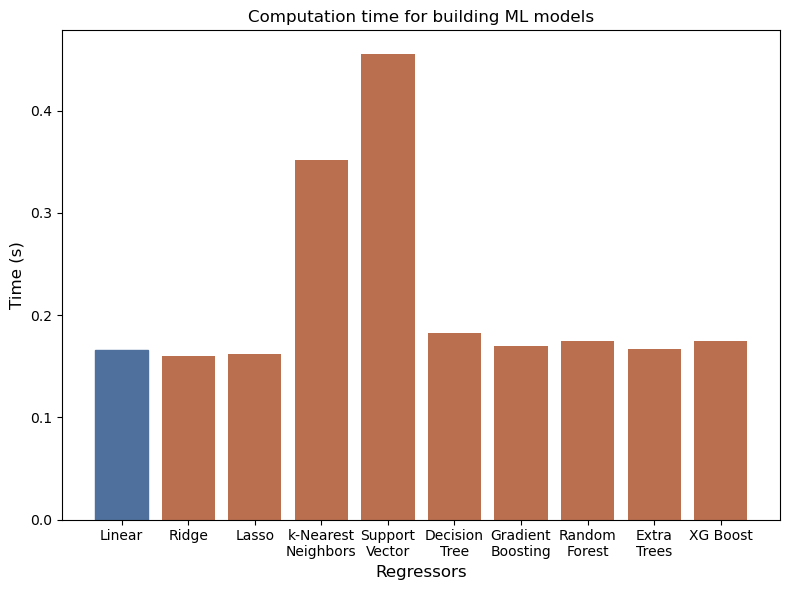

In [227]:
# Plotting computation time for building all ML models

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

performance = list(t_build.iloc[:-2,1])
titles = list(t_build.iloc[:-2,0])

bars = ax.bar(titles, performance,color='#BA704F')

# Get the third lowest value
third_lowest = sorted(performance)[2]

# Color the third lowest bar red
for i, bar in enumerate(bars):
    if performance[i] == third_lowest:
        bar.set_color('#4F709C')

ax.set_xlabel('Regressors', fontsize=12)
ax.set_ylabel('Time (s)', fontsize=12)
ax.set_title('Computation time for building ML models')
wrap_labels(ax,10)

fig.tight_layout()
plt.show()

In [228]:
t_build.to_excel('Time_Build.xlsx')

## SHAP analysis of XG Boost model

In [229]:
# Get SHAP values
xgbexplainer = shap.TreeExplainer(xgbregressor)
xgb_shap_values = xgbexplainer(X_train)
np.shape(xgb_shap_values.values)

(2400, 8)

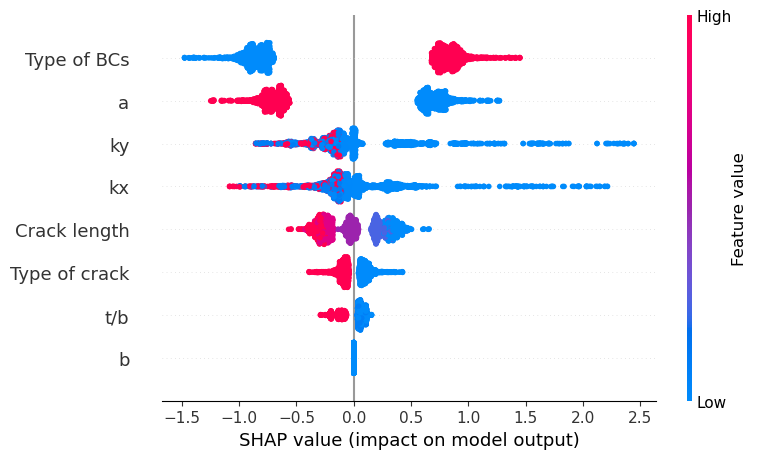

In [230]:
# Summary plot
shap.summary_plot(xgb_shap_values)

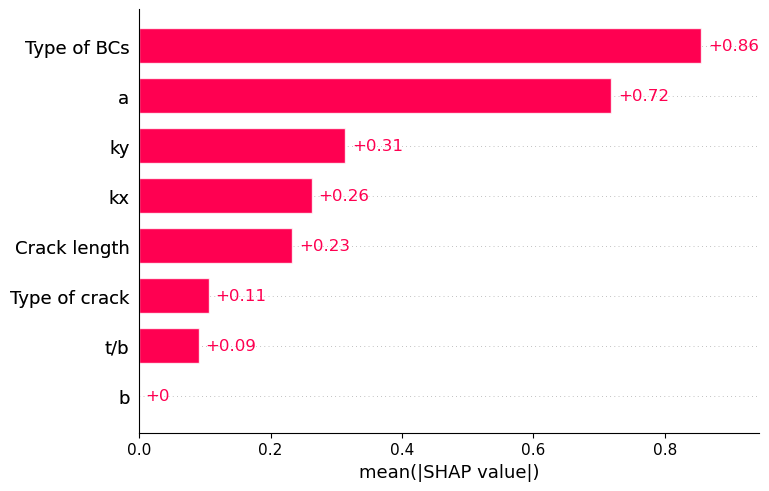

In [231]:
# Mean SHAP
shap.plots.bar(xgb_shap_values)